In [1]:
#run below code twice
from line_profiler import LineProfiler
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import plotnine as gg
import torch
# from acme.utils.loggers.terminal import TerminalLogger
import dataclasses
import chex
import haiku as hk
import jax
import jax.numpy as jnp
import optax
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import pipeline
import seaborn as sns
from dataloader import TabularDataset


training data count (251, 2)


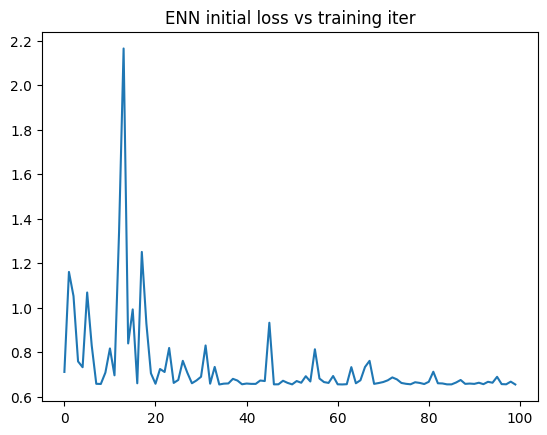

initial ENN_data train cross entropy loss 0.6656264662742615 accuracy 0.36254980079681276 recall 1.0
initial ENN_data pool cross entropy loss 0.681326687335968 accuracy 0.414 recall 1.0
initial ENN_data test cross entropy loss 0.68344646692276 accuracy 0.432 recall 1.0


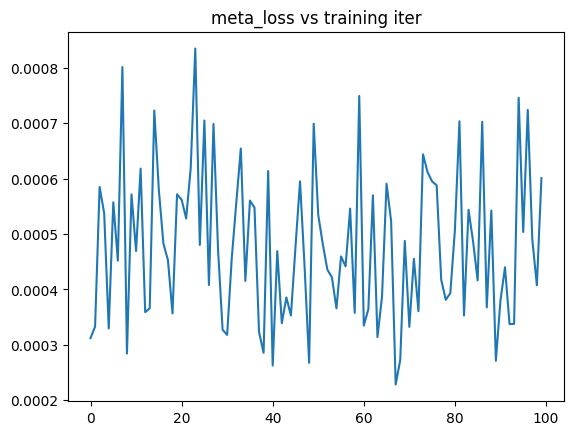

training epoch ends in  1.66 minutes.


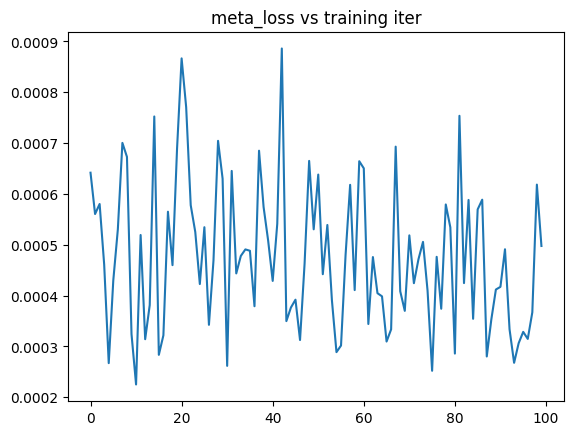

training epoch ends in  1.56 minutes.


In [ ]:
#data generated from https://github.com/dakshmittal30/Adaptive_sampling/blob/49060b32a7c95ab5f8057ff593629d64ea411c14/src/notebooks/Dataset_generator.ipynb
#predictor (a logistic regression) generated from https://github.com/dakshmittal30/Adaptive_sampling/blob/49060b32a7c95ab5f8057ff593629d64ea411c14/src/notebooks/Predictor.ipynb 
#biased data from https://github.com/dakshmittal30/Adaptive_sampling/blob/7cf3996c786ce33db90fcb7aef8584054169557c/src/notebooks/Selection_bias.ipynb 
directory = '/shared/share_mala/yuanzhe/adaptive_sampling/pipeline_datasets/'
train_csv_name = directory + 'classifier_input_dim_1_train_init_data_mean_0.0ln_1.0sig_0.1no.2000.csv'
train_csv_name = directory +'/biased_new/classifier_input_dim_1_train_init_data_mean_0.0ln_1.0sig_0.1no.2000_random_prop_score_selected_2_16.0__.csv'
test_csv_name = directory + 'classifier_input_dim_1_test_final_data_mean_0.0ln_1.0sig_0.1no.2000.csv'
pool_csv_name = directory + 'classifier_input_dim_1_pool_data_mean_0.0ln_1.0sig_0.1no.2000.csv'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


df_train = pd.read_csv(train_csv_name)
print('training data count',df_train.shape)

Z_dim = 8

dataset_cfg = pipeline.DatasetConfig(train_csv_name, test_csv_name, pool_csv_name, "EVENT_LABEL")
model_cfg = pipeline.ModelConfig(batch_size_train = 251, batch_size_test = 500, batch_size_query = 100, temp_k_subset = 0.1, hidden_sizes_weight_NN = [50,50], meta_opt_lr = 0.01, n_classes = 2, n_epoch = 5, init_train_lr = 0.05, init_train_weight_decay = 0.01, n_train_init = 100, meta_opt_weight_decay = 0.01)
train_cfg = pipeline.TrainConfig(n_train_iter = 100, n_ENN_iter = 15, ENN_opt_lr = 0.01, temp_var_recall = 0.4, z_dim = Z_dim, N_iter = 100, ENN_opt_weight_decay = 0.01) #temp_var_recall is the new variable added here
enn_cfg = pipeline.ENNConfig(basenet_hidden_sizes = [50,50],  exposed_layers = [False, True], z_dim = Z_dim, learnable_epinet_hiddens = [15,15], hidden_sizes_prior = [5,5], seed_base = 2, seed_learnable_epinet = 1, seed_prior_epinet = 0, alpha = 1.0)
 

model_predictor = torch.jit.load(directory + 'predictor_0207.pt')
model_predictor.eval()

dataset_config = dataset_cfg
dataset_test = TabularDataset(device, csv_file=dataset_config.csv_file_test, y_column=dataset_config.y_column)

# Example usage
pipeline.experiment(dataset_cfg, model_cfg, train_cfg, enn_cfg, model_predictor, device = device, if_print = 0)

In [ ]:
#%load_ext line_profiler
#profiling code - check which part
#%reload_ext line_profiler

#%lprun -f experiment experiment(dataset_cfg, model_cfg, train_cfg, enn_cfg, model_predictor, if_print = 1)